In [68]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 998
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  998


In [69]:
# Root directory for dataset
dataroot = "monets"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


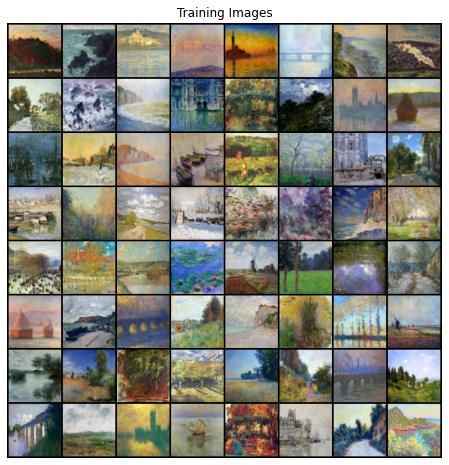

In [70]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [71]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

![Alt text](dcgan_generator.png "Title")

In [72]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [73]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [74]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [75]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [76]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [77]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[0/100][0/3]	Loss_D: 1.9141	Loss_G: 6.3047	D(x): 0.7083	D(G(z)): 0.7138 / 0.0035
[0/100][1/3]	Loss_D: 1.1385	Loss_G: 4.5450	D(x): 0.5786	D(G(z)): 0.2880 / 0.0171
[0/100][2/3]	Loss_D: 1.3988	Loss_G: 5.9691	D(x): 0.8110	D(G(z)): 0.5806 / 0.0043


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[1/100][0/3]	Loss_D: 0.7044	Loss_G: 6.2352	D(x): 0.8077	D(G(z)): 0.2861 / 0.0031
[1/100][1/3]	Loss_D: 0.8578	Loss_G: 5.8899	D(x): 0.7102	D(G(z)): 0.2530 / 0.0044
[1/100][2/3]	Loss_D: 0.8894	Loss_G: 6.8379	D(x): 0.7428	D(G(z)): 0.3061 / 0.0014


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[2/100][0/3]	Loss_D: 0.5973	Loss_G: 7.2514	D(x): 0.8323	D(G(z)): 0.2545 / 0.0012
[2/100][1/3]	Loss_D: 0.5468	Loss_G: 7.0774	D(x): 0.8178	D(G(z)): 0.1864 / 0.0014
[2/100][2/3]	Loss_D: 0.4767	Loss_G: 7.7985	D(x): 0.8386	D(G(z)): 0.2145 / 0.0005


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[3/100][0/3]	Loss_D: 0.4294	Loss_G: 8.1632	D(x): 0.8630	D(G(z)): 0.2018 / 0.0005
[3/100][1/3]	Loss_D: 0.3977	Loss_G: 8.2654	D(x): 0.8569	D(G(z)): 0.1581 / 0.0004
[3/100][2/3]	Loss_D: 0.4096	Loss_G: 9.0513	D(x): 0.8644	D(G(z)): 0.1727 / 0.0002


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[4/100][0/3]	Loss_D: 0.3490	Loss_G: 8.7877	D(x): 0.8598	D(G(z)): 0.1368 / 0.0003
[4/100][1/3]	Loss_D: 0.4198	Loss_G: 10.9108	D(x): 0.8967	D(G(z)): 0.2246 / 0.0000
[4/100][2/3]	Loss_D: 0.2763	Loss_G: 8.5583	D(x): 0.8469	D(G(z)): 0.0447 / 0.0003


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[5/100][0/3]	Loss_D: 0.6072	Loss_G: 13.8985	D(x): 0.9280	D(G(z)): 0.3657 / 0.0000
[5/100][1/3]	Loss_D: 0.3739	Loss_G: 11.4850	D(x): 0.7382	D(G(z)): 0.0014 / 0.0000
[5/100][2/3]	Loss_D: 0.2169	Loss_G: 6.3659	D(x): 0.8848	D(G(z)): 0.0387 / 0.0028


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[6/100][0/3]	Loss_D: 2.2026	Loss_G: 17.7944	D(x): 0.9762	D(G(z)): 0.8381 / 0.0000
[6/100][1/3]	Loss_D: 0.2281	Loss_G: 18.6614	D(x): 0.8216	D(G(z)): 0.0000 / 0.0000
[6/100][2/3]	Loss_D: 0.2648	Loss_G: 12.5681	D(x): 0.7979	D(G(z)): 0.0001 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[7/100][0/3]	Loss_D: 0.1346	Loss_G: 5.7933	D(x): 0.9316	D(G(z)): 0.0558 / 0.0058
[7/100][1/3]	Loss_D: 3.1010	Loss_G: 18.4771	D(x): 0.9742	D(G(z)): 0.9293 / 0.0000
[7/100][2/3]	Loss_D: 0.3326	Loss_G: 20.4826	D(x): 0.7620	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[8/100][0/3]	Loss_D: 0.3228	Loss_G: 15.6923	D(x): 0.7627	D(G(z)): 0.0000 / 0.0000
[8/100][1/3]	Loss_D: 0.0918	Loss_G: 6.8408	D(x): 0.9232	D(G(z)): 0.0043 / 0.0024
[8/100][2/3]	Loss_D: 2.8360	Loss_G: 18.9021	D(x): 0.9607	D(G(z)): 0.9012 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[9/100][0/3]	Loss_D: 0.1839	Loss_G: 20.7549	D(x): 0.8475	D(G(z)): 0.0000 / 0.0000
[9/100][1/3]	Loss_D: 0.3815	Loss_G: 16.6463	D(x): 0.7203	D(G(z)): 0.0000 / 0.0000
[9/100][2/3]	Loss_D: 0.2450	Loss_G: 8.4532	D(x): 0.8287	D(G(z)): 0.0007 / 0.0005


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[10/100][0/3]	Loss_D: 0.9812	Loss_G: 15.3099	D(x): 0.9695	D(G(z)): 0.5395 / 0.0000
[10/100][1/3]	Loss_D: 0.0862	Loss_G: 15.3859	D(x): 0.9247	D(G(z)): 0.0004 / 0.0000
[10/100][2/3]	Loss_D: 0.1451	Loss_G: 10.1124	D(x): 0.8740	D(G(z)): 0.0011 / 0.0001


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[11/100][0/3]	Loss_D: 0.4103	Loss_G: 10.9009	D(x): 0.9316	D(G(z)): 0.2475 / 0.0000
[11/100][1/3]	Loss_D: 0.1636	Loss_G: 9.5392	D(x): 0.9044	D(G(z)): 0.0536 / 0.0001
[11/100][2/3]	Loss_D: 0.4993	Loss_G: 13.2413	D(x): 0.8519	D(G(z)): 0.2380 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[12/100][0/3]	Loss_D: 0.1110	Loss_G: 10.8065	D(x): 0.9053	D(G(z)): 0.0058 / 0.0000
[12/100][1/3]	Loss_D: 0.1498	Loss_G: 7.6326	D(x): 0.9166	D(G(z)): 0.0537 / 0.0008
[12/100][2/3]	Loss_D: 1.1090	Loss_G: 21.6204	D(x): 0.9331	D(G(z)): 0.5930 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[13/100][0/3]	Loss_D: 0.4657	Loss_G: 22.6384	D(x): 0.6636	D(G(z)): 0.0000 / 0.0000
[13/100][1/3]	Loss_D: 0.1306	Loss_G: 18.7025	D(x): 0.8949	D(G(z)): 0.0000 / 0.0000
[13/100][2/3]	Loss_D: 0.0786	Loss_G: 11.4964	D(x): 0.9283	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[14/100][0/3]	Loss_D: 0.1068	Loss_G: 5.6600	D(x): 0.9585	D(G(z)): 0.0555 / 0.0070
[14/100][1/3]	Loss_D: 1.9443	Loss_G: 22.3769	D(x): 0.9704	D(G(z)): 0.8128 / 0.0000
[14/100][2/3]	Loss_D: 0.1075	Loss_G: 26.5310	D(x): 0.9037	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[15/100][0/3]	Loss_D: 0.3990	Loss_G: 25.0595	D(x): 0.7172	D(G(z)): 0.0000 / 0.0000
[15/100][1/3]	Loss_D: 0.1609	Loss_G: 20.6839	D(x): 0.8645	D(G(z)): 0.0000 / 0.0000
[15/100][2/3]	Loss_D: 0.0549	Loss_G: 13.8677	D(x): 0.9505	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[16/100][0/3]	Loss_D: 0.0395	Loss_G: 6.8977	D(x): 0.9674	D(G(z)): 0.0031 / 0.0034
[16/100][1/3]	Loss_D: 0.6537	Loss_G: 14.4339	D(x): 0.9768	D(G(z)): 0.4115 / 0.0000
[16/100][2/3]	Loss_D: 0.1158	Loss_G: 15.5700	D(x): 0.9001	D(G(z)): 0.0002 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[17/100][0/3]	Loss_D: 0.0878	Loss_G: 13.1154	D(x): 0.9222	D(G(z)): 0.0001 / 0.0000
[17/100][1/3]	Loss_D: 0.0346	Loss_G: 7.8166	D(x): 0.9687	D(G(z)): 0.0021 / 0.0008
[17/100][2/3]	Loss_D: 0.4360	Loss_G: 12.9464	D(x): 0.9266	D(G(z)): 0.2683 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[18/100][0/3]	Loss_D: 0.0998	Loss_G: 11.9828	D(x): 0.9110	D(G(z)): 0.0015 / 0.0000
[18/100][1/3]	Loss_D: 0.1351	Loss_G: 7.5591	D(x): 0.8876	D(G(z)): 0.0055 / 0.0008
[18/100][2/3]	Loss_D: 0.6000	Loss_G: 18.6630	D(x): 0.9625	D(G(z)): 0.3967 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[19/100][0/3]	Loss_D: 0.4559	Loss_G: 18.8747	D(x): 0.6982	D(G(z)): 0.0000 / 0.0000
[19/100][1/3]	Loss_D: 0.1441	Loss_G: 14.7353	D(x): 0.8821	D(G(z)): 0.0000 / 0.0000
[19/100][2/3]	Loss_D: 0.0843	Loss_G: 8.0196	D(x): 0.9306	D(G(z)): 0.0006 / 0.0005


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[20/100][0/3]	Loss_D: 0.5414	Loss_G: 17.4289	D(x): 0.9764	D(G(z)): 0.3665 / 0.0000
[20/100][1/3]	Loss_D: 0.1114	Loss_G: 18.7019	D(x): 0.9027	D(G(z)): 0.0000 / 0.0000
[20/100][2/3]	Loss_D: 0.0852	Loss_G: 15.4408	D(x): 0.9222	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[21/100][0/3]	Loss_D: 0.0958	Loss_G: 9.1888	D(x): 0.9146	D(G(z)): 0.0003 / 0.0002
[21/100][1/3]	Loss_D: 0.1556	Loss_G: 6.8394	D(x): 0.9450	D(G(z)): 0.0871 / 0.0018
[21/100][2/3]	Loss_D: 0.3408	Loss_G: 15.7435	D(x): 0.9754	D(G(z)): 0.2546 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[22/100][0/3]	Loss_D: 0.3495	Loss_G: 14.5847	D(x): 0.7501	D(G(z)): 0.0000 / 0.0000
[22/100][1/3]	Loss_D: 0.0283	Loss_G: 9.8855	D(x): 0.9729	D(G(z)): 0.0003 / 0.0001
[22/100][2/3]	Loss_D: 0.0609	Loss_G: 5.4759	D(x): 0.9717	D(G(z)): 0.0296 / 0.0064


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[23/100][0/3]	Loss_D: 0.7946	Loss_G: 20.5101	D(x): 0.9642	D(G(z)): 0.4885 / 0.0000
[23/100][1/3]	Loss_D: 0.8257	Loss_G: 18.7972	D(x): 0.6086	D(G(z)): 0.0000 / 0.0000
[23/100][2/3]	Loss_D: 0.1106	Loss_G: 13.4620	D(x): 0.9079	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[24/100][0/3]	Loss_D: 0.0753	Loss_G: 6.2864	D(x): 0.9456	D(G(z)): 0.0033 / 0.0062
[24/100][1/3]	Loss_D: 1.7416	Loss_G: 19.9300	D(x): 0.9690	D(G(z)): 0.7021 / 0.0000
[24/100][2/3]	Loss_D: 3.3958	Loss_G: 11.9187	D(x): 0.2363	D(G(z)): 0.0000 / 0.0003


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[25/100][0/3]	Loss_D: 0.4536	Loss_G: 3.7168	D(x): 0.7723	D(G(z)): 0.0152 / 0.1007
[25/100][1/3]	Loss_D: 3.1529	Loss_G: 16.3119	D(x): 0.9589	D(G(z)): 0.9116 / 0.0000
[25/100][2/3]	Loss_D: 2.3459	Loss_G: 13.4212	D(x): 0.3224	D(G(z)): 0.0000 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[26/100][0/3]	Loss_D: 0.6629	Loss_G: 5.7838	D(x): 0.6783	D(G(z)): 0.0013 / 0.0098
[26/100][1/3]	Loss_D: 0.8354	Loss_G: 6.3072	D(x): 0.8959	D(G(z)): 0.4078 / 0.0050
[26/100][2/3]	Loss_D: 0.6209	Loss_G: 9.9041	D(x): 0.9129	D(G(z)): 0.3392 / 0.0002


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[27/100][0/3]	Loss_D: 1.1833	Loss_G: 4.5247	D(x): 0.5370	D(G(z)): 0.0160 / 0.0171
[27/100][1/3]	Loss_D: 0.9139	Loss_G: 7.9707	D(x): 0.8408	D(G(z)): 0.4515 / 0.0009
[27/100][2/3]	Loss_D: 0.6716	Loss_G: 5.4984	D(x): 0.6385	D(G(z)): 0.0412 / 0.0171


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[28/100][0/3]	Loss_D: 0.5422	Loss_G: 6.1262	D(x): 0.8962	D(G(z)): 0.3026 / 0.0047
[28/100][1/3]	Loss_D: 0.4979	Loss_G: 5.2225	D(x): 0.7920	D(G(z)): 0.1607 / 0.0117
[28/100][2/3]	Loss_D: 0.6180	Loss_G: 4.3493	D(x): 0.7541	D(G(z)): 0.2046 / 0.0181


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[29/100][0/3]	Loss_D: 0.5672	Loss_G: 7.7396	D(x): 0.8674	D(G(z)): 0.3129 / 0.0013
[29/100][1/3]	Loss_D: 0.7660	Loss_G: 2.4640	D(x): 0.5847	D(G(z)): 0.0257 / 0.1452
[29/100][2/3]	Loss_D: 1.2410	Loss_G: 9.6877	D(x): 0.9286	D(G(z)): 0.6227 / 0.0002


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[30/100][0/3]	Loss_D: 0.9772	Loss_G: 5.8547	D(x): 0.5387	D(G(z)): 0.0047 / 0.0077
[30/100][1/3]	Loss_D: 0.3914	Loss_G: 2.8606	D(x): 0.8256	D(G(z)): 0.1335 / 0.0952
[30/100][2/3]	Loss_D: 1.5665	Loss_G: 11.0551	D(x): 0.9017	D(G(z)): 0.7152 / 0.0002


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[31/100][0/3]	Loss_D: 2.1715	Loss_G: 5.6505	D(x): 0.3090	D(G(z)): 0.0061 / 0.0138
[31/100][1/3]	Loss_D: 0.5721	Loss_G: 2.1357	D(x): 0.7363	D(G(z)): 0.1314 / 0.1769
[31/100][2/3]	Loss_D: 1.4548	Loss_G: 9.9190	D(x): 0.9703	D(G(z)): 0.6949 / 0.0002


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[32/100][0/3]	Loss_D: 1.2513	Loss_G: 6.3954	D(x): 0.4375	D(G(z)): 0.0048 / 0.0068
[32/100][1/3]	Loss_D: 0.3643	Loss_G: 2.9707	D(x): 0.7805	D(G(z)): 0.0378 / 0.0861
[32/100][2/3]	Loss_D: 0.9782	Loss_G: 6.0616	D(x): 0.9598	D(G(z)): 0.5272 / 0.0048


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[33/100][0/3]	Loss_D: 0.5357	Loss_G: 5.1379	D(x): 0.6921	D(G(z)): 0.0581 / 0.0153
[33/100][1/3]	Loss_D: 0.5608	Loss_G: 2.9499	D(x): 0.7349	D(G(z)): 0.1378 / 0.0764
[33/100][2/3]	Loss_D: 0.5943	Loss_G: 5.2973	D(x): 0.8909	D(G(z)): 0.3430 / 0.0086


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[34/100][0/3]	Loss_D: 0.5335	Loss_G: 3.5792	D(x): 0.7247	D(G(z)): 0.0940 / 0.0531
[34/100][1/3]	Loss_D: 0.5074	Loss_G: 3.9219	D(x): 0.8460	D(G(z)): 0.2430 / 0.0298
[34/100][2/3]	Loss_D: 0.5441	Loss_G: 4.8414	D(x): 0.8364	D(G(z)): 0.2694 / 0.0132


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[35/100][0/3]	Loss_D: 0.6566	Loss_G: 2.5213	D(x): 0.6572	D(G(z)): 0.0980 / 0.1145
[35/100][1/3]	Loss_D: 0.9215	Loss_G: 6.3453	D(x): 0.8869	D(G(z)): 0.5151 / 0.0037
[35/100][2/3]	Loss_D: 0.9826	Loss_G: 2.7792	D(x): 0.4927	D(G(z)): 0.0468 / 0.1072


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[36/100][0/3]	Loss_D: 0.8291	Loss_G: 4.9798	D(x): 0.8875	D(G(z)): 0.4685 / 0.0112
[36/100][1/3]	Loss_D: 0.5966	Loss_G: 3.7963	D(x): 0.6882	D(G(z)): 0.1249 / 0.0346
[36/100][2/3]	Loss_D: 0.6333	Loss_G: 4.6165	D(x): 0.8071	D(G(z)): 0.2881 / 0.0206


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[37/100][0/3]	Loss_D: 0.7116	Loss_G: 2.9775	D(x): 0.6868	D(G(z)): 0.1807 / 0.0718
[37/100][1/3]	Loss_D: 0.8251	Loss_G: 6.8807	D(x): 0.8314	D(G(z)): 0.4296 / 0.0032
[37/100][2/3]	Loss_D: 1.8248	Loss_G: 0.9247	D(x): 0.3012	D(G(z)): 0.0241 / 0.4699


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[38/100][0/3]	Loss_D: 2.0234	Loss_G: 7.4356	D(x): 0.9456	D(G(z)): 0.7957 / 0.0016
[38/100][1/3]	Loss_D: 1.4099	Loss_G: 4.3532	D(x): 0.3735	D(G(z)): 0.0141 / 0.0296
[38/100][2/3]	Loss_D: 0.5475	Loss_G: 2.4836	D(x): 0.7759	D(G(z)): 0.1937 / 0.1179


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[39/100][0/3]	Loss_D: 0.7488	Loss_G: 4.0664	D(x): 0.8972	D(G(z)): 0.4339 / 0.0320
[39/100][1/3]	Loss_D: 0.6324	Loss_G: 3.9588	D(x): 0.7433	D(G(z)): 0.2092 / 0.0284
[39/100][2/3]	Loss_D: 0.7548	Loss_G: 3.3399	D(x): 0.6629	D(G(z)): 0.2200 / 0.0446


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[40/100][0/3]	Loss_D: 0.6127	Loss_G: 4.9735	D(x): 0.8717	D(G(z)): 0.3519 / 0.0105
[40/100][1/3]	Loss_D: 0.6254	Loss_G: 3.3721	D(x): 0.6672	D(G(z)): 0.1023 / 0.0650
[40/100][2/3]	Loss_D: 0.6434	Loss_G: 4.9794	D(x): 0.8511	D(G(z)): 0.3342 / 0.0133


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[41/100][0/3]	Loss_D: 0.6156	Loss_G: 4.5085	D(x): 0.7599	D(G(z)): 0.2242 / 0.0183
[41/100][1/3]	Loss_D: 0.6791	Loss_G: 3.6517	D(x): 0.7202	D(G(z)): 0.2156 / 0.0434
[41/100][2/3]	Loss_D: 0.6327	Loss_G: 5.9037	D(x): 0.8336	D(G(z)): 0.3199 / 0.0048


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[42/100][0/3]	Loss_D: 0.7409	Loss_G: 2.6556	D(x): 0.6041	D(G(z)): 0.0884 / 0.1249
[42/100][1/3]	Loss_D: 0.9414	Loss_G: 6.8536	D(x): 0.8762	D(G(z)): 0.4930 / 0.0031
[42/100][2/3]	Loss_D: 0.9644	Loss_G: 2.4553	D(x): 0.4797	D(G(z)): 0.0381 / 0.1083


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[43/100][0/3]	Loss_D: 0.9871	Loss_G: 6.9449	D(x): 0.9393	D(G(z)): 0.5297 / 0.0047
[43/100][1/3]	Loss_D: 0.8249	Loss_G: 4.9957	D(x): 0.6382	D(G(z)): 0.0315 / 0.0133
[43/100][2/3]	Loss_D: 0.4697	Loss_G: 4.1374	D(x): 0.8464	D(G(z)): 0.2009 / 0.0290


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[44/100][0/3]	Loss_D: 0.7990	Loss_G: 7.0462	D(x): 0.9022	D(G(z)): 0.4530 / 0.0028
[44/100][1/3]	Loss_D: 1.1251	Loss_G: 3.6333	D(x): 0.5168	D(G(z)): 0.0534 / 0.0452
[44/100][2/3]	Loss_D: 1.2065	Loss_G: 5.5401	D(x): 0.8101	D(G(z)): 0.5094 / 0.0089


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[45/100][0/3]	Loss_D: 0.5189	Loss_G: 4.7503	D(x): 0.7333	D(G(z)): 0.1167 / 0.0155
[45/100][1/3]	Loss_D: 0.4699	Loss_G: 4.2054	D(x): 0.8003	D(G(z)): 0.1842 / 0.0240
[45/100][2/3]	Loss_D: 0.5289	Loss_G: 4.5381	D(x): 0.8007	D(G(z)): 0.2041 / 0.0148


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[46/100][0/3]	Loss_D: 0.5256	Loss_G: 5.1584	D(x): 0.8191	D(G(z)): 0.2426 / 0.0111
[46/100][1/3]	Loss_D: 0.4268	Loss_G: 4.6674	D(x): 0.8094	D(G(z)): 0.1559 / 0.0145
[46/100][2/3]	Loss_D: 0.7168	Loss_G: 4.8927	D(x): 0.7321	D(G(z)): 0.2601 / 0.0110


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[47/100][0/3]	Loss_D: 0.6590	Loss_G: 6.1770	D(x): 0.7993	D(G(z)): 0.3056 / 0.0047
[47/100][1/3]	Loss_D: 0.5585	Loss_G: 3.7364	D(x): 0.6722	D(G(z)): 0.0468 / 0.0354
[47/100][2/3]	Loss_D: 0.6475	Loss_G: 7.4622	D(x): 0.9112	D(G(z)): 0.3909 / 0.0012


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[48/100][0/3]	Loss_D: 0.5455	Loss_G: 4.8009	D(x): 0.6694	D(G(z)): 0.0325 / 0.0149
[48/100][1/3]	Loss_D: 0.4768	Loss_G: 5.5140	D(x): 0.9049	D(G(z)): 0.2637 / 0.0095
[48/100][2/3]	Loss_D: 0.4246	Loss_G: 5.0052	D(x): 0.8133	D(G(z)): 0.1471 / 0.0124


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[49/100][0/3]	Loss_D: 0.4028	Loss_G: 4.5863	D(x): 0.8253	D(G(z)): 0.1575 / 0.0160
[49/100][1/3]	Loss_D: 0.5585	Loss_G: 5.0701	D(x): 0.7911	D(G(z)): 0.2363 / 0.0100
[49/100][2/3]	Loss_D: 0.4684	Loss_G: 2.8576	D(x): 0.7334	D(G(z)): 0.0821 / 0.0666


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[50/100][0/3]	Loss_D: 0.7868	Loss_G: 8.5573	D(x): 0.9443	D(G(z)): 0.4807 / 0.0005
[50/100][1/3]	Loss_D: 0.9593	Loss_G: 4.4776	D(x): 0.4969	D(G(z)): 0.0076 / 0.0169
[50/100][2/3]	Loss_D: 0.3310	Loss_G: 4.2688	D(x): 0.9489	D(G(z)): 0.2281 / 0.0166


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[51/100][0/3]	Loss_D: 0.3793	Loss_G: 5.9603	D(x): 0.9330	D(G(z)): 0.2493 / 0.0037
[51/100][1/3]	Loss_D: 0.2558	Loss_G: 5.0760	D(x): 0.8345	D(G(z)): 0.0536 / 0.0086
[51/100][2/3]	Loss_D: 0.3383	Loss_G: 4.4450	D(x): 0.8569	D(G(z)): 0.1461 / 0.0148


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[52/100][0/3]	Loss_D: 0.5370	Loss_G: 6.6026	D(x): 0.8818	D(G(z)): 0.3064 / 0.0021
[52/100][1/3]	Loss_D: 0.5506	Loss_G: 4.0982	D(x): 0.6632	D(G(z)): 0.0547 / 0.0232
[52/100][2/3]	Loss_D: 0.6210	Loss_G: 7.3569	D(x): 0.9323	D(G(z)): 0.3942 / 0.0011


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[53/100][0/3]	Loss_D: 0.4237	Loss_G: 5.2325	D(x): 0.7177	D(G(z)): 0.0422 / 0.0096
[53/100][1/3]	Loss_D: 0.4094	Loss_G: 5.3390	D(x): 0.8722	D(G(z)): 0.2085 / 0.0080
[53/100][2/3]	Loss_D: 0.2995	Loss_G: 6.0926	D(x): 0.8998	D(G(z)): 0.1593 / 0.0032


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[54/100][0/3]	Loss_D: 0.2884	Loss_G: 4.8322	D(x): 0.8232	D(G(z)): 0.0715 / 0.0110
[54/100][1/3]	Loss_D: 0.3617	Loss_G: 5.8006	D(x): 0.8875	D(G(z)): 0.1954 / 0.0042
[54/100][2/3]	Loss_D: 0.2662	Loss_G: 5.6873	D(x): 0.8600	D(G(z)): 0.0932 / 0.0046


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[55/100][0/3]	Loss_D: 0.4022	Loss_G: 6.7181	D(x): 0.8910	D(G(z)): 0.2240 / 0.0018
[55/100][1/3]	Loss_D: 0.4637	Loss_G: 4.9456	D(x): 0.7490	D(G(z)): 0.1000 / 0.0089
[55/100][2/3]	Loss_D: 0.4875	Loss_G: 7.5977	D(x): 0.8770	D(G(z)): 0.2669 / 0.0008


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[56/100][0/3]	Loss_D: 0.2286	Loss_G: 5.9829	D(x): 0.8426	D(G(z)): 0.0387 / 0.0042
[56/100][1/3]	Loss_D: 0.2780	Loss_G: 6.2071	D(x): 0.9205	D(G(z)): 0.1622 / 0.0032
[56/100][2/3]	Loss_D: 0.5445	Loss_G: 8.0179	D(x): 0.8160	D(G(z)): 0.2306 / 0.0014


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[57/100][0/3]	Loss_D: 0.5231	Loss_G: 4.8049	D(x): 0.7309	D(G(z)): 0.0678 / 0.0129
[57/100][1/3]	Loss_D: 1.0516	Loss_G: 12.6087	D(x): 0.9369	D(G(z)): 0.5326 / 0.0000
[57/100][2/3]	Loss_D: 2.0055	Loss_G: 4.9459	D(x): 0.2471	D(G(z)): 0.0012 / 0.1118


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[58/100][0/3]	Loss_D: 0.9036	Loss_G: 6.2987	D(x): 0.9622	D(G(z)): 0.3663 / 0.0100
[58/100][1/3]	Loss_D: 0.3081	Loss_G: 6.7740	D(x): 0.9241	D(G(z)): 0.1428 / 0.0022
[58/100][2/3]	Loss_D: 0.2158	Loss_G: 4.9242	D(x): 0.8595	D(G(z)): 0.0352 / 0.0101


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[59/100][0/3]	Loss_D: 0.3865	Loss_G: 5.6372	D(x): 0.9084	D(G(z)): 0.2320 / 0.0066
[59/100][1/3]	Loss_D: 0.3123	Loss_G: 5.3710	D(x): 0.8390	D(G(z)): 0.1077 / 0.0083
[59/100][2/3]	Loss_D: 0.2271	Loss_G: 5.3091	D(x): 0.9046	D(G(z)): 0.1014 / 0.0089


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[60/100][0/3]	Loss_D: 0.2910	Loss_G: 5.7363	D(x): 0.9189	D(G(z)): 0.1697 / 0.0054
[60/100][1/3]	Loss_D: 0.3321	Loss_G: 4.6987	D(x): 0.8138	D(G(z)): 0.0893 / 0.0124
[60/100][2/3]	Loss_D: 0.3513	Loss_G: 6.6224	D(x): 0.9129	D(G(z)): 0.2071 / 0.0018


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[61/100][0/3]	Loss_D: 0.2315	Loss_G: 5.2783	D(x): 0.8365	D(G(z)): 0.0400 / 0.0070
[61/100][1/3]	Loss_D: 0.3233	Loss_G: 5.3610	D(x): 0.8771	D(G(z)): 0.1598 / 0.0062
[61/100][2/3]	Loss_D: 0.3201	Loss_G: 7.1638	D(x): 0.9102	D(G(z)): 0.1889 / 0.0011


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[62/100][0/3]	Loss_D: 0.2668	Loss_G: 5.3647	D(x): 0.8084	D(G(z)): 0.0296 / 0.0063
[62/100][1/3]	Loss_D: 0.3273	Loss_G: 6.0472	D(x): 0.9085	D(G(z)): 0.1897 / 0.0033
[62/100][2/3]	Loss_D: 0.2842	Loss_G: 7.0483	D(x): 0.9043	D(G(z)): 0.1590 / 0.0014


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[63/100][0/3]	Loss_D: 0.2886	Loss_G: 5.2373	D(x): 0.8000	D(G(z)): 0.0428 / 0.0081
[63/100][1/3]	Loss_D: 0.3199	Loss_G: 6.8670	D(x): 0.9389	D(G(z)): 0.2137 / 0.0015
[63/100][2/3]	Loss_D: 0.2562	Loss_G: 5.7192	D(x): 0.8246	D(G(z)): 0.0433 / 0.0045


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[64/100][0/3]	Loss_D: 0.2179	Loss_G: 6.3336	D(x): 0.9455	D(G(z)): 0.1420 / 0.0024
[64/100][1/3]	Loss_D: 0.2236	Loss_G: 6.4047	D(x): 0.9016	D(G(z)): 0.0981 / 0.0023
[64/100][2/3]	Loss_D: 0.1997	Loss_G: 6.3898	D(x): 0.9068	D(G(z)): 0.0913 / 0.0021


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[65/100][0/3]	Loss_D: 0.2359	Loss_G: 6.9861	D(x): 0.9228	D(G(z)): 0.1337 / 0.0014
[65/100][1/3]	Loss_D: 0.3496	Loss_G: 4.9825	D(x): 0.7918	D(G(z)): 0.0674 / 0.0084
[65/100][2/3]	Loss_D: 0.4437	Loss_G: 10.1619	D(x): 0.9544	D(G(z)): 0.3112 / 0.0001


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[66/100][0/3]	Loss_D: 0.3625	Loss_G: 8.2445	D(x): 0.7606	D(G(z)): 0.0055 / 0.0005
[66/100][1/3]	Loss_D: 0.1555	Loss_G: 5.4905	D(x): 0.9238	D(G(z)): 0.0617 / 0.0054
[66/100][2/3]	Loss_D: 1.0391	Loss_G: 16.8840	D(x): 0.9585	D(G(z)): 0.5961 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[67/100][0/3]	Loss_D: 1.6777	Loss_G: 14.2543	D(x): 0.3601	D(G(z)): 0.0000 / 0.0000
[67/100][1/3]	Loss_D: 0.1057	Loss_G: 8.1461	D(x): 0.9108	D(G(z)): 0.0008 / 0.0060
[67/100][2/3]	Loss_D: 0.3915	Loss_G: 7.0985	D(x): 0.9606	D(G(z)): 0.1954 / 0.0016


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[68/100][0/3]	Loss_D: 0.2530	Loss_G: 7.9061	D(x): 0.9709	D(G(z)): 0.1797 / 0.0009
[68/100][1/3]	Loss_D: 0.1364	Loss_G: 6.6215	D(x): 0.9184	D(G(z)): 0.0403 / 0.0030
[68/100][2/3]	Loss_D: 0.2795	Loss_G: 5.3114	D(x): 0.8819	D(G(z)): 0.1141 / 0.0076


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[69/100][0/3]	Loss_D: 0.4948	Loss_G: 7.9083	D(x): 0.8958	D(G(z)): 0.2820 / 0.0007
[69/100][1/3]	Loss_D: 0.2320	Loss_G: 6.7411	D(x): 0.8362	D(G(z)): 0.0174 / 0.0018
[69/100][2/3]	Loss_D: 0.3620	Loss_G: 4.1370	D(x): 0.8231	D(G(z)): 0.0640 / 0.0197


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[70/100][0/3]	Loss_D: 0.7347	Loss_G: 11.4805	D(x): 0.9422	D(G(z)): 0.4459 / 0.0001
[70/100][1/3]	Loss_D: 1.0690	Loss_G: 8.3498	D(x): 0.4747	D(G(z)): 0.0010 / 0.0004
[70/100][2/3]	Loss_D: 0.0638	Loss_G: 4.5222	D(x): 0.9523	D(G(z)): 0.0111 / 0.0145


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[71/100][0/3]	Loss_D: 0.7243	Loss_G: 11.2417	D(x): 0.9762	D(G(z)): 0.4707 / 0.0000
[71/100][1/3]	Loss_D: 0.3708	Loss_G: 10.3492	D(x): 0.7697	D(G(z)): 0.0010 / 0.0001
[71/100][2/3]	Loss_D: 0.3468	Loss_G: 6.3108	D(x): 0.7694	D(G(z)): 0.0038 / 0.0051


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[72/100][0/3]	Loss_D: 0.3423	Loss_G: 5.3057	D(x): 0.9241	D(G(z)): 0.1818 / 0.0087
[72/100][1/3]	Loss_D: 0.5053	Loss_G: 7.6708	D(x): 0.9131	D(G(z)): 0.2858 / 0.0007
[72/100][2/3]	Loss_D: 0.2009	Loss_G: 6.7321	D(x): 0.8766	D(G(z)): 0.0208 / 0.0021


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[73/100][0/3]	Loss_D: 0.2760	Loss_G: 4.6548	D(x): 0.8663	D(G(z)): 0.0569 / 0.0150
[73/100][1/3]	Loss_D: 0.3571	Loss_G: 6.6821	D(x): 0.9198	D(G(z)): 0.2167 / 0.0017
[73/100][2/3]	Loss_D: 0.3390	Loss_G: 5.5249	D(x): 0.7809	D(G(z)): 0.0180 / 0.0052


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[74/100][0/3]	Loss_D: 0.1418	Loss_G: 4.5567	D(x): 0.9318	D(G(z)): 0.0610 / 0.0133
[74/100][1/3]	Loss_D: 0.2086	Loss_G: 5.9237	D(x): 0.9559	D(G(z)): 0.1423 / 0.0034
[74/100][2/3]	Loss_D: 0.0922	Loss_G: 6.1489	D(x): 0.9612	D(G(z)): 0.0480 / 0.0029


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[75/100][0/3]	Loss_D: 0.1267	Loss_G: 5.1423	D(x): 0.9279	D(G(z)): 0.0398 / 0.0076
[75/100][1/3]	Loss_D: 0.2186	Loss_G: 4.8883	D(x): 0.9049	D(G(z)): 0.0919 / 0.0095
[75/100][2/3]	Loss_D: 0.1880	Loss_G: 6.3825	D(x): 0.9583	D(G(z)): 0.1281 / 0.0020


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[76/100][0/3]	Loss_D: 0.2365	Loss_G: 5.1304	D(x): 0.8632	D(G(z)): 0.0441 / 0.0075
[76/100][1/3]	Loss_D: 0.3764	Loss_G: 8.7162	D(x): 0.9325	D(G(z)): 0.2397 / 0.0003
[76/100][2/3]	Loss_D: 0.5170	Loss_G: 5.8163	D(x): 0.7276	D(G(z)): 0.0132 / 0.0038


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[77/100][0/3]	Loss_D: 0.4514	Loss_G: 9.0250	D(x): 0.9245	D(G(z)): 0.2841 / 0.0002
[77/100][1/3]	Loss_D: 0.2982	Loss_G: 6.7881	D(x): 0.8219	D(G(z)): 0.0166 / 0.0016
[77/100][2/3]	Loss_D: 0.4700	Loss_G: 5.1432	D(x): 0.7905	D(G(z)): 0.1333 / 0.0081


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[78/100][0/3]	Loss_D: 0.4413	Loss_G: 9.9983	D(x): 0.9532	D(G(z)): 0.2916 / 0.0001
[78/100][1/3]	Loss_D: 0.3125	Loss_G: 8.7897	D(x): 0.8038	D(G(z)): 0.0030 / 0.0002
[78/100][2/3]	Loss_D: 0.2051	Loss_G: 5.4385	D(x): 0.8610	D(G(z)): 0.0082 / 0.0063


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[79/100][0/3]	Loss_D: 0.2480	Loss_G: 6.4054	D(x): 0.9698	D(G(z)): 0.1798 / 0.0025
[79/100][1/3]	Loss_D: 0.0976	Loss_G: 6.3480	D(x): 0.9549	D(G(z)): 0.0462 / 0.0027
[79/100][2/3]	Loss_D: 0.1579	Loss_G: 5.2360	D(x): 0.8994	D(G(z)): 0.0375 / 0.0071


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[80/100][0/3]	Loss_D: 0.1740	Loss_G: 5.6742	D(x): 0.9553	D(G(z)): 0.1144 / 0.0049
[80/100][1/3]	Loss_D: 0.1592	Loss_G: 6.1083	D(x): 0.9402	D(G(z)): 0.0831 / 0.0035
[80/100][2/3]	Loss_D: 0.1836	Loss_G: 5.6947	D(x): 0.9153	D(G(z)): 0.0722 / 0.0051


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[81/100][0/3]	Loss_D: 0.2178	Loss_G: 6.1610	D(x): 0.9248	D(G(z)): 0.1179 / 0.0033
[81/100][1/3]	Loss_D: 0.2599	Loss_G: 5.2950	D(x): 0.8725	D(G(z)): 0.0703 / 0.0063
[81/100][2/3]	Loss_D: 0.3295	Loss_G: 8.3400	D(x): 0.9344	D(G(z)): 0.2183 / 0.0005


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[82/100][0/3]	Loss_D: 0.2426	Loss_G: 7.3822	D(x): 0.8423	D(G(z)): 0.0082 / 0.0011
[82/100][1/3]	Loss_D: 0.2352	Loss_G: 4.3332	D(x): 0.8642	D(G(z)): 0.0304 / 0.0166
[82/100][2/3]	Loss_D: 0.6058	Loss_G: 12.2093	D(x): 0.9254	D(G(z)): 0.3866 / 0.0000


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[83/100][0/3]	Loss_D: 0.3725	Loss_G: 11.8259	D(x): 0.7822	D(G(z)): 0.0004 / 0.0000
[83/100][1/3]	Loss_D: 0.2039	Loss_G: 8.7457	D(x): 0.8595	D(G(z)): 0.0003 / 0.0003
[83/100][2/3]	Loss_D: 0.0871	Loss_G: 4.3960	D(x): 0.9341	D(G(z)): 0.0129 / 0.0198


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[84/100][0/3]	Loss_D: 0.7545	Loss_G: 12.0679	D(x): 0.9798	D(G(z)): 0.4439 / 0.0000
[84/100][1/3]	Loss_D: 0.4844	Loss_G: 11.6840	D(x): 0.7078	D(G(z)): 0.0002 / 0.0000
[84/100][2/3]	Loss_D: 0.3378	Loss_G: 8.6970	D(x): 0.7934	D(G(z)): 0.0004 / 0.0005


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[85/100][0/3]	Loss_D: 0.0522	Loss_G: 5.1102	D(x): 0.9633	D(G(z)): 0.0099 / 0.0117
[85/100][1/3]	Loss_D: 0.4901	Loss_G: 8.5957	D(x): 0.9857	D(G(z)): 0.2990 / 0.0007
[85/100][2/3]	Loss_D: 0.0535	Loss_G: 7.9485	D(x): 0.9660	D(G(z)): 0.0151 / 0.0013


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[86/100][0/3]	Loss_D: 0.2618	Loss_G: 6.2839	D(x): 0.9321	D(G(z)): 0.1389 / 0.0057
[86/100][1/3]	Loss_D: 1.0154	Loss_G: 11.6564	D(x): 0.8863	D(G(z)): 0.4858 / 0.0000
[86/100][2/3]	Loss_D: 1.9928	Loss_G: 6.0631	D(x): 0.3130	D(G(z)): 0.0009 / 0.0058


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[87/100][0/3]	Loss_D: 0.2867	Loss_G: 4.2943	D(x): 0.9062	D(G(z)): 0.1161 / 0.0408
[87/100][1/3]	Loss_D: 0.6479	Loss_G: 9.8073	D(x): 0.9526	D(G(z)): 0.3393 / 0.0001
[87/100][2/3]	Loss_D: 0.3557	Loss_G: 8.8104	D(x): 0.7855	D(G(z)): 0.0015 / 0.0002


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[88/100][0/3]	Loss_D: 0.2121	Loss_G: 5.1661	D(x): 0.8519	D(G(z)): 0.0030 / 0.0085
[88/100][1/3]	Loss_D: 0.1443	Loss_G: 3.8629	D(x): 0.9632	D(G(z)): 0.0867 / 0.0302
[88/100][2/3]	Loss_D: 0.3326	Loss_G: 7.2024	D(x): 0.9632	D(G(z)): 0.2275 / 0.0009


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[89/100][0/3]	Loss_D: 0.1831	Loss_G: 6.8211	D(x): 0.8971	D(G(z)): 0.0081 / 0.0014
[89/100][1/3]	Loss_D: 0.1935	Loss_G: 4.6665	D(x): 0.8828	D(G(z)): 0.0109 / 0.0126
[89/100][2/3]	Loss_D: 0.3166	Loss_G: 2.7265	D(x): 0.8612	D(G(z)): 0.0592 / 0.0803


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[90/100][0/3]	Loss_D: 0.6559	Loss_G: 10.8967	D(x): 0.9768	D(G(z)): 0.4130 / 0.0000
[90/100][1/3]	Loss_D: 0.7821	Loss_G: 10.1988	D(x): 0.6826	D(G(z)): 0.0002 / 0.0001
[90/100][2/3]	Loss_D: 0.2670	Loss_G: 7.1609	D(x): 0.8516	D(G(z)): 0.0005 / 0.0019


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[91/100][0/3]	Loss_D: 0.0757	Loss_G: 4.5698	D(x): 0.9579	D(G(z)): 0.0103 / 0.0218
[91/100][1/3]	Loss_D: 0.1842	Loss_G: 4.5047	D(x): 0.9716	D(G(z)): 0.1325 / 0.0174
[91/100][2/3]	Loss_D: 0.2004	Loss_G: 6.4182	D(x): 0.9806	D(G(z)): 0.1539 / 0.0021


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[92/100][0/3]	Loss_D: 0.1325	Loss_G: 5.9927	D(x): 0.9129	D(G(z)): 0.0152 / 0.0033
[92/100][1/3]	Loss_D: 0.2504	Loss_G: 3.9367	D(x): 0.8556	D(G(z)): 0.0238 / 0.0256
[92/100][2/3]	Loss_D: 0.4058	Loss_G: 7.7842	D(x): 0.9663	D(G(z)): 0.2926 / 0.0005


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[93/100][0/3]	Loss_D: 0.2481	Loss_G: 7.3353	D(x): 0.8283	D(G(z)): 0.0044 / 0.0009
[93/100][1/3]	Loss_D: 0.3283	Loss_G: 3.8560	D(x): 0.8120	D(G(z)): 0.0090 / 0.0294
[93/100][2/3]	Loss_D: 0.3849	Loss_G: 5.6057	D(x): 0.9245	D(G(z)): 0.2349 / 0.0044


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[94/100][0/3]	Loss_D: 0.1579	Loss_G: 5.7410	D(x): 0.9319	D(G(z)): 0.0756 / 0.0044
[94/100][1/3]	Loss_D: 0.2139	Loss_G: 4.9173	D(x): 0.9102	D(G(z)): 0.0749 / 0.0100
[94/100][2/3]	Loss_D: 0.3980	Loss_G: 6.1219	D(x): 0.8831	D(G(z)): 0.1982 / 0.0031


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[95/100][0/3]	Loss_D: 0.4030	Loss_G: 4.7720	D(x): 0.8183	D(G(z)): 0.1030 / 0.0153
[95/100][1/3]	Loss_D: 0.7228	Loss_G: 6.9660	D(x): 0.8061	D(G(z)): 0.2969 / 0.0024
[95/100][2/3]	Loss_D: 0.5070	Loss_G: 4.5135	D(x): 0.7269	D(G(z)): 0.0429 / 0.0170


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[96/100][0/3]	Loss_D: 0.3899	Loss_G: 6.7134	D(x): 0.9291	D(G(z)): 0.2341 / 0.0029
[96/100][1/3]	Loss_D: 0.1505	Loss_G: 6.5845	D(x): 0.9086	D(G(z)): 0.0330 / 0.0041
[96/100][2/3]	Loss_D: 0.2170	Loss_G: 4.7046	D(x): 0.8659	D(G(z)): 0.0456 / 0.0206


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[97/100][0/3]	Loss_D: 0.2902	Loss_G: 6.2061	D(x): 0.9584	D(G(z)): 0.1856 / 0.0059
[97/100][1/3]	Loss_D: 0.1767	Loss_G: 5.2920	D(x): 0.8898	D(G(z)): 0.0370 / 0.0093
[97/100][2/3]	Loss_D: 0.2865	Loss_G: 3.7009	D(x): 0.8619	D(G(z)): 0.0763 / 0.0395


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[98/100][0/3]	Loss_D: 0.4949	Loss_G: 7.5421	D(x): 0.9186	D(G(z)): 0.2923 / 0.0027
[98/100][1/3]	Loss_D: 0.5892	Loss_G: 3.1787	D(x): 0.6783	D(G(z)): 0.0266 / 0.0761
[98/100][2/3]	Loss_D: 0.8301	Loss_G: 10.0256	D(x): 0.9391	D(G(z)): 0.4861 / 0.0002


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[99/100][0/3]	Loss_D: 1.3135	Loss_G: 5.3219	D(x): 0.4923	D(G(z)): 0.0071 / 0.0270
[99/100][1/3]	Loss_D: 0.4039	Loss_G: 2.2996	D(x): 0.8349	D(G(z)): 0.1081 / 0.1616
[99/100][2/3]	Loss_D: 1.0807	Loss_G: 8.9251	D(x): 0.9812	D(G(z)): 0.5679 / 0.0010


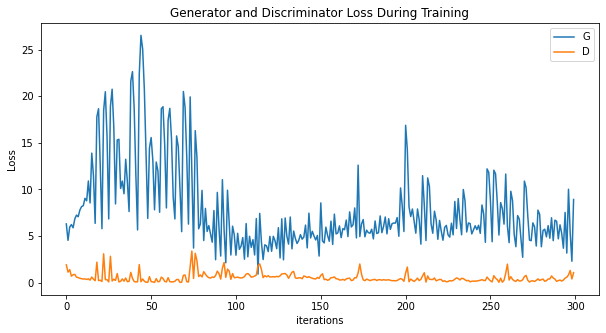

In [78]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

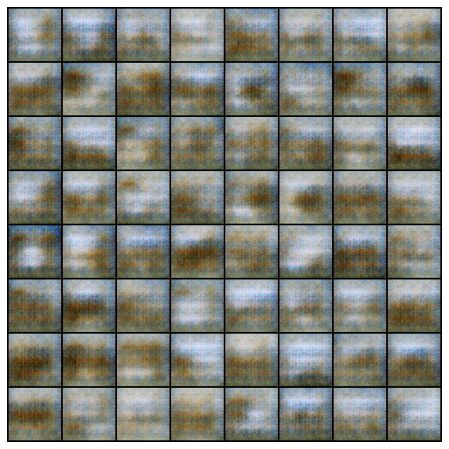

In [79]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


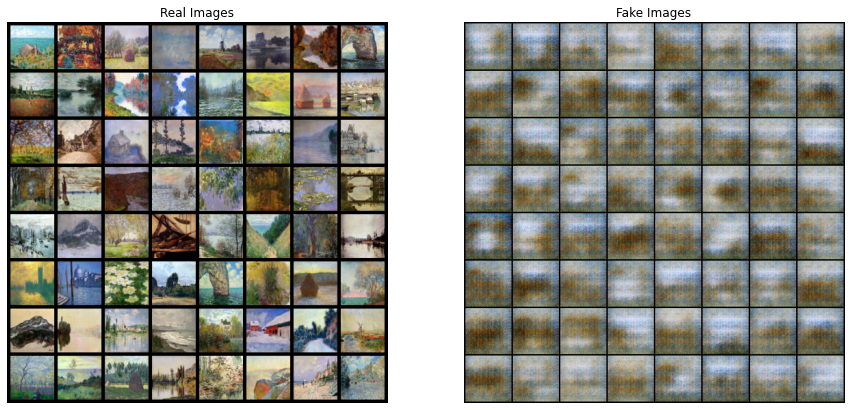

In [80]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()